## HPLA Genelet Reciever Model

In [1]:
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale

%matplotlib inline

In [2]:
plt.rc('font', family = 'serif', size = 13, weight = "bold")
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', linewidth = 2)
plt.rc('lines', linewidth = 3)
plt.rc('figure', figsize = (6, 6))
plt.rc('legend', fontsize = 13)

cm = plt.cm.get_cmap('tab20')

### Model: Sender Receiver HPLA Network in PlateReader

#### Network: G2R1 ---| G1S1, G1 repressed by rR (rR1 can be transcribed by G2)

- **Components (y)**: **G2**, **G1**, **rR1**, **Th1**, **G1rR1**, **Th1rR1**


- **Rates (p)**: $K_{p} = 0.02 (\frac{1}{s})$, $K_{5bp} = \frac{1e^{5}}{1e^{9}} (\frac{1}{nM*s})$, $K_{6bp} = \frac{1e^{6}}{1e^{9}} (\frac{1}{nM*s})$, $K_{dds} = 0.0003 (\frac{1}{s})$


- **Reactions**:

    $ production: G2 \stackrel{k_{p}}{\rightarrow} G2 + rR1 $
    
    $ repression: rR1 + G1 \stackrel{k_{5bp}}{\rightarrow} G1:rR1 $
    
    $ competition: rR1 + Th1 \stackrel{k_{6bp}}{\rightarrow} Th1:rR1 $
    
    $ degradation: G1:rR1 \stackrel{k_{dds}}{\rightarrow} G1 $
    
    $ degradation: Th1:rR1 \stackrel{k_{dds}}{\rightarrow} Th1 $


- **ODEs**:

    $\frac{d[G2]}{dt}=0$
    
    $\frac{d[G1]}{dt}=-k_{5bp}[G1][rR1]+k_{dds}[G1:rR1]$
    
    $\frac{d[G1:rR1]}{dt}=k_{5bp}[G1][rR1]-k_{dds}[G1:rR1]$
    
    $\frac{d[rR1]}{dt}=k_{p}[G2]-k_{5bp}[G1][rR1]-k_{6bp}[Th1][rR1]$
    
    $\frac{d[Th1]}{dt}=k_{dds}[G1:Th1]-k_{6bp}[Th1][rR1]$
    
    $\frac{d[Th1:rR1]}{dt}=-k_{dds}[G1:Th1]+k_{6bp}[Th1][rR1]$

    

In [3]:
def sender_reviever_model(init_vals, params, t):
    """
    ode model for G2R1 ---| G1S1.
    """
    G20, G10, rR10, Th10, G1rR10, Th1rR10 = init_vals
    G2, G1, rR1, Th1, G1rR1, Th1rR1 = [G20], [G10], [rR10], [Th10], [G1rR10], [Th1rR10]
    Kp, K5bp, K6bp, Kdds = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        dG2 = G2[-1]
        
        dG1 = G1[-1] + (- K5bp*G1[-1]*rR1[-1] + Kdds*G1rR1[-1]) * dt
        if dG1 > G10: dG1 = G10
        if dG1 < 0: dG1 = 0
        
        dG1rR1 = G1rR1[-1] + (K5bp*G1[-1]*rR1[-1] - Kdds*G1rR1[-1]) * dt
        if dG1rR1 > G10: dG1rR1 = G10
        if dG1rR1 < 0: dG1rR1 = 0
        
        drR1 = rR1[-1] + (Kp*G2[-1] - K5bp*G1[-1]*rR1[-1] - K6bp*Th1[-1]*rR1[-1]) * dt
        
        dTh1 = Th1[-1] + (Kdds*Th1rR1[-1] - K6bp*Th1[-1]*rR1[-1]) * dt
        if dTh1 > Th10: dTh1 = Th10
        if dTh1 < 0: dTh1 = 0
        
        dTh1rR1 = Th1rR1[-1] +  (- Kdds*Th1rR1[-1] + K6bp*Th1[-1]*rR1[-1]) * dt
        if dTh1rR1 > Th10: dTh1rR1 = Th10
        if dTh1rR1 < 0: dTh1rR1 = 0
        
        G2.append(dG2); G1.append(dG1); G1rR1.append(dG1rR1); rR1.append(drR1); Th1.append(dTh1); Th1rR1.append(dTh1rR1);
        
    return np.stack([G2, G1, rR1, Th1, G1rR1, Th1rR1]).T


#### Simulate genelet repression at different repressor dose

- 100nM G1 reacts with different amount of rR1, track G1.
- 50nM threshold concentration.

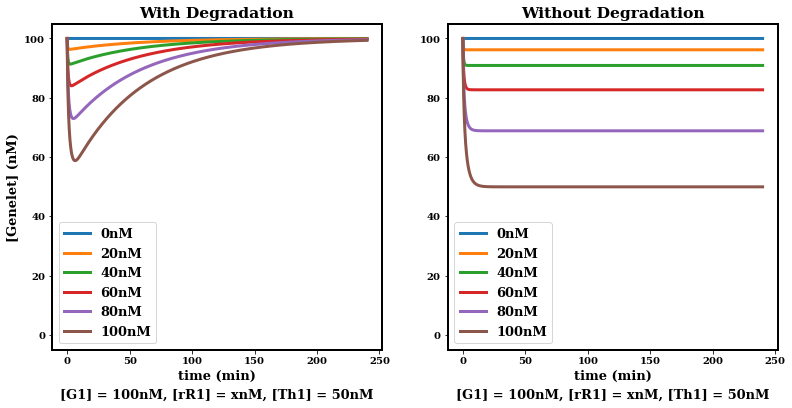

In [4]:
fig = plt.figure(figsize = (13, 6))

plt.subplot(1, 2, 1)

for i in range(0, 11, 2):
    # G20 = 0nM, G10 = 100nM, rR10 = xnM, Th10 = 50, G1rR10 = 0, Th1rR10 = 0
    init_vals = [0, 100, 10*i, 50, 0, 0]

    # Kp = 0.02 (1/s), K5bp = 1e5/1e9(1/nM/s), K6bp = 1e6/1e9(1/nM/s), Kdds = 0.0003(1/s)
    params = [0.02, 1e5/1e9, 1e6/1e9, 0.0003]

    # 1 hr = 60 min = 3600sec
    timestamp = np.arange(60 * 60 * 4)

    data = sender_reviever_model(init_vals, params, timestamp)

    # plt.plot(timestamp / 60, data[:, 0], label = "G2")
    plt.plot(timestamp / 60, data[:, 1], label = "{:.0f}nM".format(10*i))
    plt.xlabel("time (min)\n[G1] = 100nM, [rR1] = xnM, [Th1] = 50nM", linespacing = 1.5, weight = "bold")
    plt.ylabel("[Genelet] (nM)", weight = "bold")
    plt.title("With Degradation", weight = "bold")
    plt.ylim(-5, 105)

plt.legend()

plt.subplot(1, 2, 2)

for i in range(0, 11, 2):
    # G20 = 0nM, G10 = 100nM, rR10 = 100, Th10 = 50, G1rR10 = 0, Th1rR10 = 0
    init_vals = [0, 100, 10*i, 50, 0, 0]

    # Kp = 0.02 (1/s), K5bp = 1e5/1e9(1/nM/s), K6bp = 1e6/1e9(1/nM/s), Kdds = 0 (1/s)
    params = [0.02, 1e5/1e9, 1e6/1e9, 0.]

    # 1 hr = 60 min = 3600sec
    timestamp = np.arange(60 * 60 * 4)

    data = sender_reviever_model(init_vals, params, timestamp)

    # plt.plot(timestamp / 60, data[:, 0], label = "G2")
    plt.plot(timestamp / 60, data[:, 1], label = "{:.0f}nM".format(10*i))
    plt.xlabel("time (min)\n[G1] = 100nM, [rR1] = xnM, [Th1] = 50nM", linespacing = 1.5, weight = "bold")
#     plt.ylabel("[Genelet] (nM)")
    plt.title("Without Degradation", weight = "bold")
    plt.ylim(-5, 105)

plt.legend()
plt.show()

If we wanna measure the dose-reponse curve in platereaders: 

 - **with degradation**, given we cannot constantly supply repressor, all conditions goes to FULLY ON at steady-state, as we will be constantly removing/degrading RNA repressor with RNaseH degradation.
 
 
 - We can do it **without degradation**, but it leads to conditions different from our h-channel experiments (where there is a constant supply of RNA repressor and a constant depletion by RNase H)

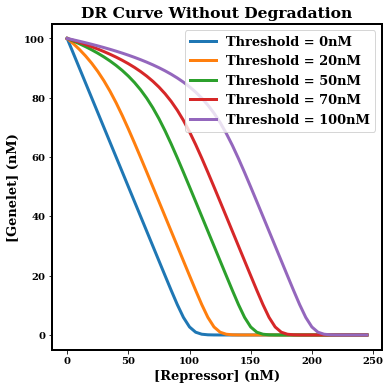

In [5]:
fig = plt.figure(figsize = (13, 6))

plt.subplot(1, 2, 1)

thresholds = [0, 20, 50, 70, 100]

for j in range(len(thresholds)):
    
    target = []

    for i in range(0, 250, 5):
        # G20 = 0nM, G10 = 100nM, rR10 = 100, Th10 = 50, G1rR10 = 0, Th1rR10 = 0
        init_vals = [0, 100, i, thresholds[j], 0, 0]

        # Kp = 0.02 (1/s), K5bp = 1e5/1e9(1/nM/s), K6bp = 1e6/1e9(1/nM/s), Kdds = 0.0003(1/s)
        params = [0.02, 1e5/1e9, 1e6/1e9, 0.]

        # 1 hr = 60 min = 3600sec
        timestamp = np.arange(60 * 60 * 1)

        data = sender_reviever_model(init_vals, params, timestamp)

        target.append(data[-1, 1])

    
    plt.plot(range(0, 250, 5), target, label = "Threshold = {:.0f}nM".format(thresholds[j]))
plt.xlabel("[Repressor] (nM)", linespacing = 1.5, weight = "bold")
plt.ylabel("[Genelet] (nM)", weight = "bold")
plt.title("DR Curve Without Degradation", weight = "bold")
# plt.ylim(-5, 105); plt.xlim(-5, 205)

plt.legend()
plt.show()

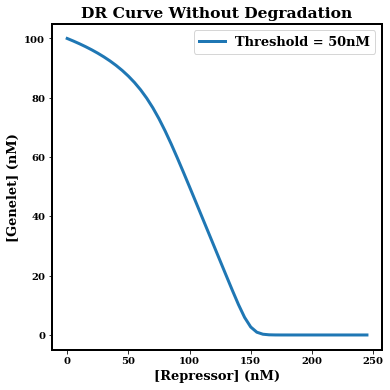

In [6]:
fig = plt.figure(figsize = (13, 6))

plt.subplot(1, 2, 1)

thresholds = [50]

for j in range(len(thresholds)):
    
    target = []

    for i in range(0, 250, 5):
        # G20 = 0nM, G10 = 100nM, rR10 = 100, Th10 = 50, G1rR10 = 0, Th1rR10 = 0
        init_vals = [0, 100, i, thresholds[j], 0, 0]

        # Kp = 0.02 (1/s), K5bp = 1e5/1e9(1/nM/s), K6bp = 1e6/1e9(1/nM/s), Kdds = 0.0003(1/s)
        params = [0.02, 1e5/1e9, 1e6/1e9, 0.]

        # 1 hr = 60 min = 3600sec
        timestamp = np.arange(60 * 60 * 1)

        data = sender_reviever_model(init_vals, params, timestamp)

        target.append(data[-1, 1])

    
    plt.plot(range(0, 250, 5), target, label = "Threshold = {:.0f}nM".format(thresholds[j]))
plt.xlabel("[Repressor] (nM)", linespacing = 1.5, weight = "bold")
plt.ylabel("[Genelet] (nM)", weight = "bold")
plt.title("DR Curve Without Degradation", weight = "bold")
# plt.ylim(-5, 105); plt.xlim(-5, 205)

plt.legend()
plt.show()

So conclusion is we **can** do this in platereader without degradation, but not sure how meaningfull this will be.

We can also see that G1 decreases linearly when no threshold is added, until plato-ing at 100nM. And introduction of threshold strand leads to the desired inverse-sigmoidal curve.

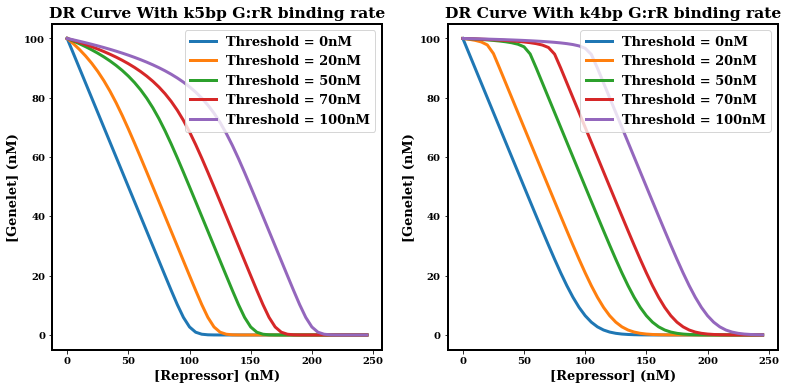

In [10]:
fig = plt.figure(figsize = (13, 6))

plt.subplot(1, 2, 1)

thresholds = [0, 20, 50, 70, 100]

for j in range(len(thresholds)):
    
    target = []

    for i in range(0, 250, 5):
        # G20 = 0nM, G10 = 100nM, rR10 = 100, Th10 = 50, G1rR10 = 0, Th1rR10 = 0
        init_vals = [0, 100, i, thresholds[j], 0, 0]

        # Kp = 0.02 (1/s), K5bp = 1e5/1e9(1/nM/s), K6bp = 1e6/1e9(1/nM/s), Kdds = 0.0003(1/s)
        params = [0.02, 1e5/1e9, 1e6/1e9, 0.]

        # 1 hr = 60 min = 3600sec
        timestamp = np.arange(60 * 60 * 1)

        data = sender_reviever_model(init_vals, params, timestamp)

        target.append(data[-1, 1])

    
    plt.plot(range(0, 250, 5), target, label = "Threshold = {:.0f}nM".format(thresholds[j]))
plt.xlabel("[Repressor] (nM)", linespacing = 1.5, weight = "bold")
plt.ylabel("[Genelet] (nM)", weight = "bold")
plt.title("DR Curve With k5bp G:rR binding rate", weight = "bold")
# plt.ylim(-5, 105); plt.xlim(-5, 205)

plt.legend()

plt.subplot(1, 2, 2)

thresholds = [0, 20, 50, 70, 100]

for j in range(len(thresholds)):
    
    target = []

    for i in range(0, 250, 5):
        # G20 = 0nM, G10 = 100nM, rR10 = 100, Th10 = 50, G1rR10 = 0, Th1rR10 = 0
        init_vals = [0, 100, i, thresholds[j], 0, 0]

        # Kp = 0.02 (1/s), K5bp = 1e5/1e9(1/nM/s), K6bp = 1e6/1e9(1/nM/s), Kdds = 0.0003(1/s)
        params = [0.02, 1e4/1e9, 1e6/1e9, 0.]

        # 1 hr = 60 min = 3600sec
        timestamp = np.arange(60 * 60 * 4)

        data = sender_reviever_model(init_vals, params, timestamp)

        target.append(data[-1, 1])

    
    plt.plot(range(0, 250, 5), target, label = "Threshold = {:.0f}nM".format(thresholds[j]))
plt.xlabel("[Repressor] (nM)", linespacing = 1.5, weight = "bold")
plt.ylabel("[Genelet] (nM)", weight = "bold")
plt.title("DR Curve With k4bp G:rR binding rate", weight = "bold")
# plt.ylim(-5, 105); plt.xlim(-5, 205)

plt.legend()
plt.show()

Meanwhile, I tried lowering the genelet:repressor binding rate, and it actually gives a better looking dose-response curve. But we have to keep in mind of the trade-off, that a slower binding rate leads to longer time needed for reaching steady-state, leading to a slower circuit.